# Modeling Notebook

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [2]:
# import dataset
df = pd.read_csv('..\\data\\telecom_data.csv')

# Handle object types for international plan and voice mail plan
df.loc[df['international plan'] == 'no', 'international plan'] = 0
df.loc[df['international plan'] == 'yes', 'international plan'] = 1 

df.loc[df['voice mail plan'] == 'no', 'voice mail plan'] = 0
df.loc[df['voice mail plan']== 'yes', 'voice mail plan'] = 1

# Change churn to values: 1 (churned/True) 0 (no churn/False)
df.loc[df['churn'] == True, 'churn'] = 1
df.loc[df['churn'] == False, 'churn'] = 0

# going to create backup df and drop phone number from original df
# phone number could be used as unique id, but it doesn't seem necessary
df_backup = df.copy()
df = df.drop(['phone number'], axis=1)

# casting int values to churn, voice mail plan, and international plan cols
objs = ['international plan', 'voice mail plan', 'churn']

for o in objs:
    df = df.astype({o: int})
    
# dropping area code
df = df.drop(['area code'], axis=1)

# check df
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Handle international calls to bin them into categories easier.

In [3]:
# handle international calls to bin them into categories easier.
df['total intl calls'].value_counts()

3     668
4     619
2     489
5     472
6     336
7     218
1     160
8     116
9     109
10     50
11     28
0      18
12     15
13     14
15      7
14      6
18      3
16      2
19      1
17      1
20      1
Name: total intl calls, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x221dc4b9250>,
 'caps': [<matplotlib.lines.Line2D at 0x221dc4b9940>,
 'boxes': [<matplotlib.lines.Line2D at 0x221dc4a1eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x221dc4c6040>],
 'fliers': [<matplotlib.lines.Line2D at 0x221dc4c63a0>],
 'means': []}

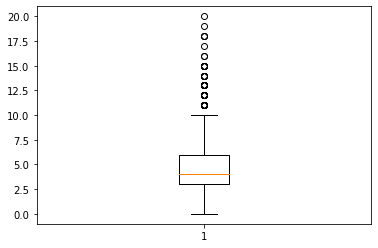

In [4]:
plt.boxplot(df['total intl calls'])

In [5]:
df['total intl calls'].describe()

count    3333.000000
mean        4.479448
std         2.461214
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: total intl calls, dtype: float64

In [6]:
# range is 0-20 for international calls with most concentrated from 0-10
# I will bin into cats: low, moderate, and high with values <3, 3-6, and >6

list_tmp = []

for index, row in df.iterrows():
    if row['total intl calls'] < 3:
        list_tmp.append('low')
    elif row['total intl calls'] > 6:
        list_tmp.append('high')
    else:
        list_tmp.append('moderate')

df['total_intl_calls'] = list_tmp

df['total_intl_calls'].describe()

count         3333
unique           3
top       moderate
freq          2095
Name: total_intl_calls, dtype: object

In [9]:
cats = ['state', 'international plan', 'total_intl_calls',
        'customer service calls', 'voice mail plan']

# Baseline Model

In [15]:
y = df['churn']
# dropping # vmail messages because its distribution isn't normal
X = df.drop(['churn', 'total intl calls', 'number vmail messages'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
X_train_cats = X_train[cats]
X_train_cats

,state,international plan,total_intl_calls,customer service calls,voice mail plan
367,MD,0,moderate,1,0
3103,DE,0,low,2,0
549,OK,0,moderate,4,1
2531,RI,0,moderate,1,0
2378,OR,0,high,3,0
...,...,...,...,...,...
1095,ID,0,moderate,1,0
1130,PA,0,low,1,0
1294,OR,0,moderate,1,0
860,HI,0,moderate,2,0


In [20]:
# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_cats)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cats),
    index=X_train_cats.index,
    # we are dummying multiple columns at once, so stack the names
    columns=np.hstack(ohe.categories_)
)
X_train_ohe

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,2,3,4,5,6,7,8,9,0,1
367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2531,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
numerics = 